In [138]:
print("Loading required libraries...")


import numpy as np
import random

# For loading and displaying images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline

# OpenCV for image manipulation
import cv2

# Pandas for loading csv files and dataframes
import pandas as pd

# Fix error with TF and Keras
import tensorflow as tf
tf.python.control_flow_ops = tf

# For Keras
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D

print("Libraries loaded")


Loading required libraries...
Libraries loaded


### Get Data

In [7]:
import os
import platform

In [26]:
os_type = platform.system()
print(os_type)

joiner = '/'

if os_type == 'Windows':
    joiner = '\\'

path = os.getcwd()
print(path)


data_path = path + joiner + r'data' + joiner
data_log_path = data_path + r'driving_log.csv'
images_path = data_path + r'IMG'


print(data_log_path,images_path)

Windows
C:\Users\avinash\version-control\SDC\term1\P3
C:\Users\avinash\version-control\SDC\term1\P3\data\driving_log.csv C:\Users\avinash\version-control\SDC\term1\P3\data\IMG


In [15]:
data_log = pd.read_csv(data_log_path)

print(data_log.describe())

          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


(array([  6.00000000e+00,   7.00000000e+00,   1.01000000e+02,
          3.94000000e+02,   5.76700000e+03,   1.40500000e+03,
          3.04000000e+02,   4.40000000e+01,   6.00000000e+00,
          2.00000000e+00]),
 array([-0.9426954 , -0.74842586, -0.55415632, -0.35988678, -0.16561724,
         0.0286523 ,  0.22292184,  0.41719138,  0.61146092,  0.80573046,  1.        ]),
 <a list of 10 Patch objects>)

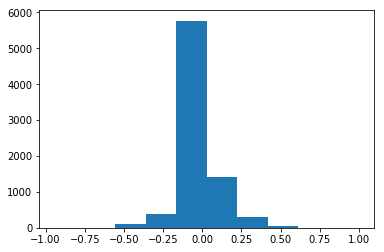

In [43]:
plt.hist(data_log['steering'])

In [33]:
''' 
This function generates paths for left, center and right cameras images

Arguments: 
Takes 3 arguments
path: where data is stored
data: data_log's panda variable
row_num: number of row we are selecting

Outputs:
A tuple with 3 paths for left, center and right camera images respectively
'''
def get_image_paths(path,data,row_num):
    l_img_path = path + data.iloc[row_num]['left'].strip()
    c_img_path = path + data.iloc[row_num]['center'].strip()
    r_img_path = path + data.iloc[row_num]['right'].strip()
    
    return (l_img_path,c_img_path,r_img_path)

Left image path = C:\Users\avinash\version-control\SDC\term1\P3\data\IMG/left_2016_12_01_13_30_48_287.jpg
center image path = C:\Users\avinash\version-control\SDC\term1\P3\data\IMG/center_2016_12_01_13_30_48_287.jpg
right image path = C:\Users\avinash\version-control\SDC\term1\P3\data\IMG/right_2016_12_01_13_30_48_287.jpg


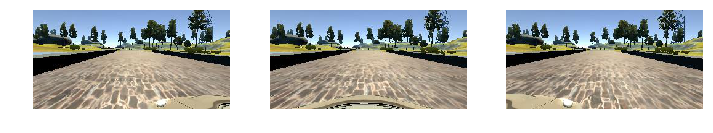

In [32]:
images_path = get_image_paths(data_path,data_log,0)

print("Left image path = "+ images_path[0])
print("center image path = "+ images_path[1])
print("right image path = " + images_path[2])

gs1 = gridspec.GridSpec(1,3)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(3):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = mpimg.imread(images_path[i])
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [35]:
print(type(img))
print(img.shape)

<class 'numpy.ndarray'>
(160, 320, 3)


### Pre-processing and Image generator

In [203]:
new_height,new_width,channels = 66,200,3 #global variables

In [243]:
def get_resized_img(file_path):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(new_width,new_height),interpolation=cv2.INTER_AREA)
    return img

def preprocess_images(row_data,validation = False):
    # Get paths
    l_img_path = data_path + row_data.iloc[0]['left'].strip()
    c_img_path = data_path + row_data.iloc[0]['center'].strip()
    r_img_path = data_path + row_data.iloc[0]['right'].strip()
    
    img = get_resized_img(c_img_path)
    
    if validation:
        return img
    
    return img

In [204]:
def image_generator(data,batch_size=32,validation=False):
    length_of_data = len(data)
    
    # Create empty numpy array batches for images and steering
    batch_images = np.zeros((batch_size,new_height,new_width,channels))
    batch_steering = np.zeros(batch_size)
    
    while True:
        for i in range(batch_size):
            # Randomly select one of the capured images from data_log
            selector = np.random.randint(length_of_data)
            row_data = data.iloc[[selector]]
            
            # Pre-process the image differently for training and validation image generators
            x = preprocess_images(row_data,validation)
            y = row_data.iloc[0]['steering']
            
            batch_images[i] = x 
            batch_steering[i] = y
        yield batch_images,batch_steering
            

In [189]:
image6 = preprocess_images(data_log.iloc[[1]])
print(type(image6))
print(image6.shape)

<class 'numpy.ndarray'>
(66, 200, 3)


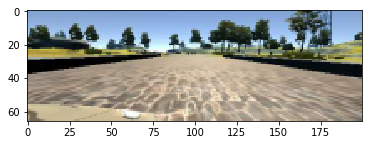

In [188]:
plt.imshow(image6)

#### Test image genrator

In [253]:
to_test_gen = image_generator(data_log,3,validation=True)


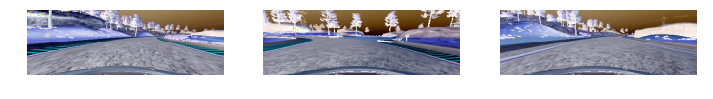

In [254]:
count = 0
for x,y in to_test_gen:
    length = len(x)
    gs1 = gridspec.GridSpec(1,length)
    gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
    plt.figure(figsize=(12,12))
    for j in range(length):
        ax1 = plt.subplot(gs1[j])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        img = x[j]
        plt.subplot(1,length,j+1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()
    count +=1
    if count>0:
        break

### Define Model

In [192]:
def nvidia_model():
    ch, row, col = 3, 66, 200  # camera format
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=(row, col,ch),output_shape=(row, col,ch)))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, border_mode="valid"))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

### Sanity check

[ 0.3679529  0.        -0.2781274]


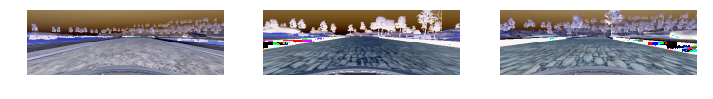

In [191]:
sanity_batch_data2 = np.zeros((3,66,200,3))
sanity_batch_steering = np.zeros(3)

sanity_batch_data2[0] = get_resized_img(data_path+data_log.iloc[54]['center'].strip())
sanity_batch_data2[1] = get_resized_img(data_path+data_log.iloc[0]['center'].strip())
sanity_batch_data2[2] = get_resized_img(data_path+data_log.iloc[154]['center'].strip())

sanity_batch_steering[0] = data_log.iloc[54]['steering']
sanity_batch_steering[1] = data_log.iloc[0]['steering']
sanity_batch_steering[2] = data_log.iloc[154]['steering']

print(sanity_batch_steering)

gs1 = gridspec.GridSpec(1,3)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(3):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = sanity_batch_data2[i]
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

#### Intialize model

In [193]:
model = nvidia_model()

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_23 (Lambda)               (None, 66, 200, 3)    0           lambda_input_23[0][0]            
____________________________________________________________________________________________________
convolution2d_84 (Convolution2D) (None, 31, 98, 24)    1824        lambda_23[0][0]                  
____________________________________________________________________________________________________
activation_45 (Activation)       (None, 31, 98, 24)    0           convolution2d_84[0][0]           
____________________________________________________________________________________________________
convolution2d_85 (Convolution2D) (None, 14, 47, 36)    21636       activation_45[0][0]              
___________________________________________________________________________________________

#### Train on sanity data

In [194]:
model.fit(sanity_batch_data2,sanity_batch_steering,nb_epoch=20)

Epoch 1/20
3/3 [==============================] - 4s - loss: 0.0712
Epoch 2/20
3/3 [==============================] - 0s - loss: 0.0542
Epoch 3/20
3/3 [==============================] - 0s - loss: 0.0330
Epoch 4/20
3/3 [==============================] - 0s - loss: 0.0254
Epoch 5/20
3/3 [==============================] - 0s - loss: 0.0193
Epoch 6/20
3/3 [==============================] - 0s - loss: 0.0172
Epoch 7/20
3/3 [==============================] - 0s - loss: 0.0125
Epoch 8/20
3/3 [==============================] - 0s - loss: 0.0107
Epoch 9/20
3/3 [==============================] - 0s - loss: 0.0043
Epoch 10/20
3/3 [==============================] - 0s - loss: 0.0023
Epoch 11/20
3/3 [==============================] - 0s - loss: 0.0093
Epoch 12/20
3/3 [==============================] - 0s - loss: 0.0063
Epoch 13/20
3/3 [==============================] - 0s - loss: 0.0029
Epoch 14/20
3/3 [==============================] - 0s - loss: 0.0015
Epoch 15/20
3/3 [==========================

#### Test on same sanity data

In [196]:
model2.evaluate(sanity_batch_data2,sanity_batch_steering)
model2.predict(sanity_batch_data2)

3/3 [==============================] - 0s


array([[ 0.33247584],
       [-0.01209209],
       [-0.24604522]], dtype=float32)

### Dude do real training

In [257]:
training_generator = image_generator(data_log,2)
validation_generator = image_generator(data_log,2)

model2 = nvidia_model()

In [258]:
history = model2.fit_generator(training_generator,samples_per_epoch=10,nb_epoch=10,validation_data=validation_generator,nb_val_samples=2)

Epoch 1/10
10/10 [==============================] - 6s - loss: 2.6405e-04 - val_loss: 1.1345e-05
Epoch 2/10
10/10 [==============================] - 0s - loss: 0.0156 - val_loss: 0.0114
Epoch 3/10
10/10 [==============================] - 0s - loss: 0.0266 - val_loss: 1.5599e-04
Epoch 4/10
10/10 [==============================] - 0s - loss: 0.0067 - val_loss: 0.1063
Epoch 5/10
10/10 [==============================] - 0s - loss: 0.0288 - val_loss: 0.0616
Epoch 6/10
10/10 [==============================] - 0s - loss: 0.0571 - val_loss: 0.0017
Epoch 7/10
10/10 [==============================] - 0s - loss: 0.0141 - val_loss: 0.0252
Epoch 8/10
10/10 [==============================] - 0s - loss: 0.0339 - val_loss: 0.0251
Epoch 9/10
10/10 [==============================] - 0s - loss: 1.3355e-05 - val_loss: 0.0469
Epoch 10/10
10/10 [==============================] - 0s - loss: 0.0415 - val_loss: 5.4711e-04


### Save model 
As json and it's weight as hdfs5 format

In [198]:
 if not os.path.exists("./outputs"):
        os.makedirs("./outputs")


In [259]:
model_json = model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [260]:
model.save_weights("model.h5")

In [197]:
'''

model.fit_generator(
    image_generator(data_log,2),
    samples_per_epoch=10,
    nb_epoch=10,
  )

json_string = model.to_json()

def get_paths_angle(row_data):
    l_img_path = data_path + row_data.iloc[0]['left'].strip()
    c_img_path = data_path + row_data.iloc[0]['center'].strip()
    r_img_path = data_path + row_data.iloc[0]['right'].strip()
    angle = row_data.iloc[0]['steering']
    
    return (l_img_path,c_img_path,r_img_path,angle)


'''

'\n\nmodel.fit_generator(\n    image_generator(data_log,2),\n    samples_per_epoch=10,\n    nb_epoch=10,\n  )\n\njson_string = model.to_json()\n'

In [231]:
def kkk(x):
    k = 0
    c='remo'
    while True:
        if k > x:
            return
        else:
            yield k,c
            k = k+1

ddd = kkk(20)
            
for z,ff in ddd:
    print(ff)

remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
remo
